In [1]:
# Importando as bibliotecas necessárias
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

In [2]:
# Download do dataset MNIST into data dir
! wget https://pjreddie.com/media/files/mnist_train.csv -P data

--2024-12-07 20:48:59--  https://pjreddie.com/media/files/mnist_train.csv
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109575994 (104M) [text/csv]
Saving to: ‘data/mnist_train.csv’

mnist_train.csv     100%[===================>] 104.50M  13.3MB/s    in 9.2s    

2024-12-07 20:49:09 (11.4 MB/s) - ‘data/mnist_train.csv’ saved [109575994/109575994]



In [3]:
class MNISTDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file, header=None)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # A primeira coluna é o rótulo
        label = self.data.iloc[idx, 0]
        # As demais colunas são os pixels da imagem
        image = self.data.iloc[idx, 1:].values.astype('uint8').reshape(28, 28)

        if self.transform:
            image = self.transform(image)

        return image, label

In [4]:
# Transformação para converter a imagem para tensor
transform = transforms.Compose([
    transforms.ToTensor(),      # Convertendo a imagem PIL para tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalizando a imagem
])

# Criando o dataset
mnist_dataset = MNISTDataset("./data/mnist_train.csv", transform=transform)

# Transformação para converter a imagem para tensor
transform = transforms.Compose([
    transforms.ToPILImage(),    # Convertendo o array numpy para imagem PIL
    transforms.ToTensor(),      # Convertendo a imagem PIL para tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalizando a imagem
])

# Criando o dataset
mnist_dataset = MNISTDataset("./data/mnist_train.csv", transform=transform)

In [5]:
# Criando índices aleatórios para os subsets de treino e teste
np.random.seed(42)
indices = np.arange(len(mnist_dataset))
np.random.shuffle(indices)

# Dividindo os índices em trainset e testset
num_train = 1000
num_val = 500
num_test = 500
train_indices = indices[:num_train]  # Primeiros 1.000 índices para o trainset
val_indices = indices[num_train:num_train+num_val]  # Próximos 500 índices para o valset
test_indices = indices[num_train+num_val:num_train+num_val+num_test]  # Mais 500 para o testset

trainset = Subset(mnist_dataset, train_indices)
valset = Subset(mnist_dataset, val_indices)
testset = Subset(mnist_dataset, test_indices)

# Criando DataLoaders para os subsets
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

In [6]:
def train_model(model, trainloader, valloader, criterion, optimizer, num_epochs=5):
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': []
    }

    for epoch in range(num_epochs):
        # Treinamento
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
            inputs, labels = data

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        history['train_losses'].append(train_loss)
        history['train_accuracies'].append(train_acc)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.2f}%')

        # Validação
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(valloader)
        val_acc = 100 * correct / total
        history['val_losses'].append(val_loss)
        history['val_accuracies'].append(val_acc)
        print(f'Epoch {epoch+1}, Val Loss: {val_loss:.3f}, Val Accuracy: {val_acc:.2f}%')

    print('Treinamento concluído')
    return history


def test_model(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Acurácia da rede na base de teste: {100 * correct / total:.2f}%')

In [24]:
class CNN(nn.Module):
    def __init__(self, initialize_weights=True, dropout=0.2, num_filters_conv1=6, num_filters_conv2=12, n_hidden=64):
        super(CNN, self).__init__()
        self.num_filters_conv2 = num_filters_conv2
        self.conv1 = nn.Conv2d(1, num_filters_conv1, 5)
        self.conv2 = nn.Conv2d(num_filters_conv1, num_filters_conv2, 5)
        self.fc1 = nn.Linear(num_filters_conv2 * 4 * 4, n_hidden)
        self.fc2 = nn.Linear(n_hidden, 10)
        self.dropout = nn.Dropout(dropout)

        if initialize_weights:
            self._initialize_weights()

    def forward(self, x):
        # CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        # Flatten
        x = x.view(-1, self.num_filters_conv2 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

In [8]:
model = CNN(
    initialize_weights=True,
    dropout=0.2
)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [10]:
# Treinando a CNN
history = train_model(
    model=model,
    trainloader=trainloader,
    valloader=valloader,
    criterion=criterion,
    optimizer=optimizer
)

100%|██████████| 16/16 [00:00<00:00, 19.71it/s]


Epoch 1, Train Loss: 2.301, Train Accuracy: 15.00%
Epoch 1, Val Loss: 2.233, Val Accuracy: 26.00%


100%|██████████| 16/16 [00:00<00:00, 29.57it/s]


Epoch 2, Train Loss: 2.140, Train Accuracy: 28.70%
Epoch 2, Val Loss: 1.950, Val Accuracy: 43.00%


100%|██████████| 16/16 [00:00<00:00, 29.78it/s]


Epoch 3, Train Loss: 1.585, Train Accuracy: 50.70%
Epoch 3, Val Loss: 0.932, Val Accuracy: 75.40%


100%|██████████| 16/16 [00:00<00:00, 30.05it/s]


Epoch 4, Train Loss: 0.851, Train Accuracy: 73.00%
Epoch 4, Val Loss: 0.510, Val Accuracy: 85.40%


100%|██████████| 16/16 [00:00<00:00, 29.83it/s]


Epoch 5, Train Loss: 0.530, Train Accuracy: 83.50%
Epoch 5, Val Loss: 0.459, Val Accuracy: 85.80%
Treinamento concluído


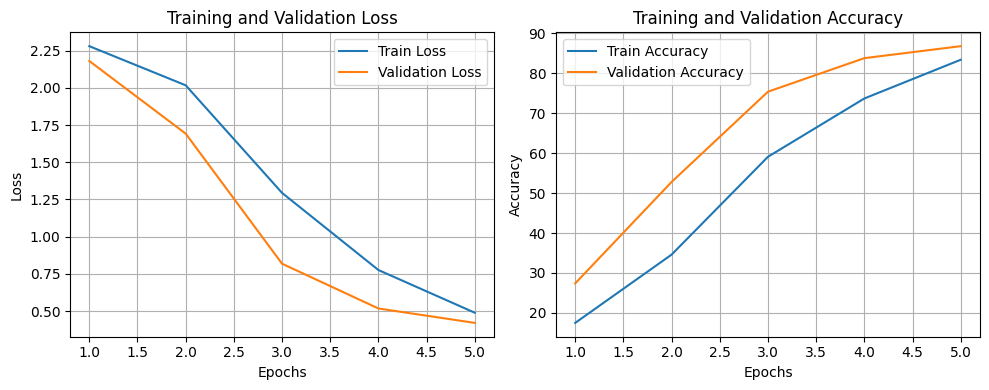

In [21]:
epochs = range(1, len(history['train_losses']) + 1)

# Plot de losses
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.grid()
plt.plot(epochs, history['train_losses'], label='Train Loss')
plt.plot(epochs, history['val_losses'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot de accuracies
plt.subplot(1, 2, 2)
plt.grid()
plt.plot(epochs, history['train_accuracies'], label='Train Accuracy')
plt.plot(epochs, history['val_accuracies'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
test_model(model, testloader)

Acurácia da rede na base de teste: 87.80%


## Exercícios

### Exercício 1
Na CNN implementada, execute experimentos variando:
- O número de filtros convolucionais em `self.conv1` (6 e 8)
- O número de filtros convolucionais em `self.conv2` (12 e 16)

Ao final, observe qual combinação desempenha melhor no conjunto de testes.

Dica: Adicionar argumentos no construtor da classe para determinar o número de filtros em cada camada pode ser útil para inicializar diversos modelos.

In [23]:
# Processo semelhante ao Grid Search
param_combinations = [
    (6, 12),
    (6, 16),
    (8, 12),
    (8, 16)
]

for nfc1, nfc2 in param_combinations:
    print(f'Número de filtros em conv1: {nfc1} e conv2: {nfc2}')
    model = CNN(initialize_weights=True,
                dropout=0.2,
                num_filters_conv1=nfc1,
                num_filters_conv2=nfc2)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    history = train_model(model, trainloader, valloader, criterion, optimizer)
    test_model(model, testloader)
    print()

Número de filtros em conv1: 6 e conv2: 12


100%|██████████| 16/16 [00:00<00:00, 28.22it/s]


Epoch 1, Train Loss: 2.241, Train Accuracy: 21.70%
Epoch 1, Val Loss: 2.099, Val Accuracy: 32.40%


100%|██████████| 16/16 [00:00<00:00, 28.67it/s]


Epoch 2, Train Loss: 1.836, Train Accuracy: 41.90%
Epoch 2, Val Loss: 1.372, Val Accuracy: 60.80%


100%|██████████| 16/16 [00:00<00:00, 29.14it/s]


Epoch 3, Train Loss: 1.121, Train Accuracy: 62.30%
Epoch 3, Val Loss: 0.751, Val Accuracy: 78.00%


100%|██████████| 16/16 [00:00<00:00, 28.00it/s]


Epoch 4, Train Loss: 0.688, Train Accuracy: 76.60%
Epoch 4, Val Loss: 0.539, Val Accuracy: 82.60%


100%|██████████| 16/16 [00:00<00:00, 27.96it/s]


Epoch 5, Train Loss: 0.502, Train Accuracy: 84.00%
Epoch 5, Val Loss: 0.456, Val Accuracy: 85.60%
Treinamento concluído
Acurácia da rede na base de teste: 88.40%

Número de filtros em conv1: 6 e conv2: 16


100%|██████████| 16/16 [00:00<00:00, 28.04it/s]


Epoch 1, Train Loss: 2.267, Train Accuracy: 21.20%
Epoch 1, Val Loss: 2.140, Val Accuracy: 37.80%


100%|██████████| 16/16 [00:00<00:00, 27.98it/s]


Epoch 2, Train Loss: 1.868, Train Accuracy: 44.30%
Epoch 2, Val Loss: 1.503, Val Accuracy: 52.60%


100%|██████████| 16/16 [00:00<00:00, 28.06it/s]


Epoch 3, Train Loss: 1.120, Train Accuracy: 64.50%
Epoch 3, Val Loss: 0.687, Val Accuracy: 80.00%


100%|██████████| 16/16 [00:00<00:00, 21.09it/s]


Epoch 4, Train Loss: 0.625, Train Accuracy: 79.80%
Epoch 4, Val Loss: 0.469, Val Accuracy: 86.20%


100%|██████████| 16/16 [00:00<00:00, 18.99it/s]


Epoch 5, Train Loss: 0.400, Train Accuracy: 86.70%
Epoch 5, Val Loss: 0.374, Val Accuracy: 88.60%
Treinamento concluído
Acurácia da rede na base de teste: 89.80%

Número de filtros em conv1: 8 e conv2: 12


100%|██████████| 16/16 [00:00<00:00, 25.40it/s]


Epoch 1, Train Loss: 2.327, Train Accuracy: 12.30%
Epoch 1, Val Loss: 2.237, Val Accuracy: 19.00%


100%|██████████| 16/16 [00:00<00:00, 27.65it/s]


Epoch 2, Train Loss: 2.119, Train Accuracy: 29.90%
Epoch 2, Val Loss: 1.912, Val Accuracy: 49.20%


100%|██████████| 16/16 [00:00<00:00, 28.19it/s]


Epoch 3, Train Loss: 1.565, Train Accuracy: 51.90%
Epoch 3, Val Loss: 1.033, Val Accuracy: 67.60%


100%|██████████| 16/16 [00:00<00:00, 28.37it/s]


Epoch 4, Train Loss: 0.889, Train Accuracy: 69.10%
Epoch 4, Val Loss: 0.614, Val Accuracy: 81.60%


100%|██████████| 16/16 [00:00<00:00, 28.24it/s]


Epoch 5, Train Loss: 0.624, Train Accuracy: 79.30%
Epoch 5, Val Loss: 0.511, Val Accuracy: 83.00%
Treinamento concluído
Acurácia da rede na base de teste: 84.40%

Número de filtros em conv1: 8 e conv2: 16


100%|██████████| 16/16 [00:00<00:00, 28.44it/s]


Epoch 1, Train Loss: 2.258, Train Accuracy: 19.00%
Epoch 1, Val Loss: 2.110, Val Accuracy: 43.80%


100%|██████████| 16/16 [00:00<00:00, 28.60it/s]


Epoch 2, Train Loss: 1.791, Train Accuracy: 39.80%
Epoch 2, Val Loss: 1.207, Val Accuracy: 66.00%


100%|██████████| 16/16 [00:00<00:00, 27.36it/s]


Epoch 3, Train Loss: 1.015, Train Accuracy: 64.90%
Epoch 3, Val Loss: 0.500, Val Accuracy: 86.40%


100%|██████████| 16/16 [00:00<00:00, 28.48it/s]


Epoch 4, Train Loss: 0.576, Train Accuracy: 80.30%
Epoch 4, Val Loss: 0.388, Val Accuracy: 88.00%


100%|██████████| 16/16 [00:00<00:00, 28.75it/s]


Epoch 5, Train Loss: 0.428, Train Accuracy: 85.50%
Epoch 5, Val Loss: 0.374, Val Accuracy: 86.80%
Treinamento concluído
Acurácia da rede na base de teste: 89.40%



**R:** Entre os parâmetros solicitados, o que apresentou melhor resultado na validação foi para a combinação (6, 16), com acurária de 89,8%.

### Exercício 2

Na CNN implementada, execute 5 treinamentos variando aleatoriamente o número de neurônios de saída em `self.fc1` (o valor atual é 64 e também deve ser alterado na entrada da próxima camada).

Como você determinaria qual foi o melhor valor?

In [25]:
for i in range(5):
  num_neurons = np.random.randint(10, 100)
  model = CNN(initialize_weights=True, dropout=0.2, n_hidden=num_neurons)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  history = train_model(model, trainloader, valloader, criterion, optimizer)

  print(f'Número de neurônios na camada fully connected: {num_neurons}')
  test_model(model, testloader)
  print()

100%|██████████| 16/16 [00:00<00:00, 22.25it/s]


Epoch 1, Train Loss: 2.303, Train Accuracy: 12.50%
Epoch 1, Val Loss: 2.261, Val Accuracy: 19.80%


100%|██████████| 16/16 [00:00<00:00, 20.49it/s]


Epoch 2, Train Loss: 2.175, Train Accuracy: 25.10%
Epoch 2, Val Loss: 2.033, Val Accuracy: 35.00%


100%|██████████| 16/16 [00:00<00:00, 19.25it/s]


Epoch 3, Train Loss: 1.758, Train Accuracy: 40.60%
Epoch 3, Val Loss: 1.369, Val Accuracy: 62.00%


100%|██████████| 16/16 [00:00<00:00, 27.98it/s]


Epoch 4, Train Loss: 1.105, Train Accuracy: 61.30%
Epoch 4, Val Loss: 0.815, Val Accuracy: 73.60%


100%|██████████| 16/16 [00:00<00:00, 28.06it/s]


Epoch 5, Train Loss: 0.687, Train Accuracy: 77.30%
Epoch 5, Val Loss: 0.523, Val Accuracy: 85.00%
Treinamento concluído
Número de neurônios na camada fully connected: 55
Acurácia da rede na base de teste: 86.20%



100%|██████████| 16/16 [00:00<00:00, 27.06it/s]


Epoch 1, Train Loss: 2.258, Train Accuracy: 15.80%
Epoch 1, Val Loss: 2.126, Val Accuracy: 40.40%


100%|██████████| 16/16 [00:00<00:00, 27.75it/s]


Epoch 2, Train Loss: 1.873, Train Accuracy: 43.80%
Epoch 2, Val Loss: 1.398, Val Accuracy: 60.80%


100%|██████████| 16/16 [00:00<00:00, 27.57it/s]


Epoch 3, Train Loss: 1.068, Train Accuracy: 65.60%
Epoch 3, Val Loss: 0.573, Val Accuracy: 81.20%


100%|██████████| 16/16 [00:00<00:00, 27.17it/s]


Epoch 4, Train Loss: 0.640, Train Accuracy: 80.10%
Epoch 4, Val Loss: 0.468, Val Accuracy: 86.60%


100%|██████████| 16/16 [00:00<00:00, 27.12it/s]


Epoch 5, Train Loss: 0.470, Train Accuracy: 84.70%
Epoch 5, Val Loss: 0.431, Val Accuracy: 87.00%
Treinamento concluído
Número de neurônios na camada fully connected: 78
Acurácia da rede na base de teste: 89.20%



100%|██████████| 16/16 [00:00<00:00, 28.22it/s]


Epoch 1, Train Loss: 2.279, Train Accuracy: 18.00%
Epoch 1, Val Loss: 2.157, Val Accuracy: 32.40%


100%|██████████| 16/16 [00:00<00:00, 27.91it/s]


Epoch 2, Train Loss: 1.949, Train Accuracy: 34.30%
Epoch 2, Val Loss: 1.545, Val Accuracy: 52.00%


100%|██████████| 16/16 [00:00<00:00, 29.02it/s]


Epoch 3, Train Loss: 1.176, Train Accuracy: 61.80%
Epoch 3, Val Loss: 0.653, Val Accuracy: 81.20%


100%|██████████| 16/16 [00:00<00:00, 27.83it/s]


Epoch 4, Train Loss: 0.692, Train Accuracy: 77.40%
Epoch 4, Val Loss: 0.473, Val Accuracy: 85.80%


100%|██████████| 16/16 [00:00<00:00, 23.27it/s]


Epoch 5, Train Loss: 0.491, Train Accuracy: 84.50%
Epoch 5, Val Loss: 0.379, Val Accuracy: 86.80%
Treinamento concluído
Número de neurônios na camada fully connected: 90
Acurácia da rede na base de teste: 88.80%



100%|██████████| 16/16 [00:00<00:00, 20.91it/s]


Epoch 1, Train Loss: 2.288, Train Accuracy: 16.00%
Epoch 1, Val Loss: 2.220, Val Accuracy: 29.00%


100%|██████████| 16/16 [00:00<00:00, 19.62it/s]


Epoch 2, Train Loss: 2.025, Train Accuracy: 34.60%
Epoch 2, Val Loss: 1.675, Val Accuracy: 48.40%


100%|██████████| 16/16 [00:00<00:00, 19.74it/s]


Epoch 3, Train Loss: 1.336, Train Accuracy: 56.00%
Epoch 3, Val Loss: 0.904, Val Accuracy: 71.00%


100%|██████████| 16/16 [00:00<00:00, 20.04it/s]


Epoch 4, Train Loss: 0.781, Train Accuracy: 75.50%
Epoch 4, Val Loss: 0.583, Val Accuracy: 82.80%


100%|██████████| 16/16 [00:00<00:00, 27.88it/s]


Epoch 5, Train Loss: 0.578, Train Accuracy: 81.60%
Epoch 5, Val Loss: 0.469, Val Accuracy: 85.20%
Treinamento concluído
Número de neurônios na camada fully connected: 61
Acurácia da rede na base de teste: 87.60%



100%|██████████| 16/16 [00:00<00:00, 27.62it/s]


Epoch 1, Train Loss: 2.308, Train Accuracy: 13.50%
Epoch 1, Val Loss: 2.267, Val Accuracy: 10.80%


100%|██████████| 16/16 [00:00<00:00, 28.90it/s]


Epoch 2, Train Loss: 2.212, Train Accuracy: 19.60%
Epoch 2, Val Loss: 2.145, Val Accuracy: 21.80%


100%|██████████| 16/16 [00:00<00:00, 29.07it/s]


Epoch 3, Train Loss: 1.960, Train Accuracy: 33.40%
Epoch 3, Val Loss: 1.735, Val Accuracy: 43.00%


100%|██████████| 16/16 [00:00<00:00, 28.75it/s]


Epoch 4, Train Loss: 1.454, Train Accuracy: 50.60%
Epoch 4, Val Loss: 1.064, Val Accuracy: 64.60%


100%|██████████| 16/16 [00:00<00:00, 27.73it/s]


Epoch 5, Train Loss: 0.950, Train Accuracy: 66.70%
Epoch 5, Val Loss: 0.648, Val Accuracy: 81.00%
Treinamento concluído
Número de neurônios na camada fully connected: 20
Acurácia da rede na base de teste: 78.80%



**R:** A variação de neurônios da camada de saída apresentou melhor resultado na validação com uma quantidade de 78 neurônios e acurácia da rede na base de teste de 89.20%.